# LSTM Traning (BentoML)

LSTM training with BentoML model management and serving

## Preparation

In [1]:
%cd stock-pred
%bookmark REPO_BASE_DIR

/mlsteam/lab/stock-pred


In [2]:
%pip install "bentoml[all]"  # install BentoML
%pip install -r requirements.txt

import IPython

# automatically restart kernel
IPython.Application.instance().kernel.do_shutdown(restart=True)

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


{'status': 'ok', 'restart': True}

In [1]:
%cd -b REPO_BASE_DIR

# Forces to use CPU rather than GPU
# NVIDIA drivers of higher versions have messy implimentation of LSTM!
# Ref: https://github.com/mozilla/DeepSpeech/issues/3088#issuecomment-656056969
# Ref: https://github.com/tensorflow/tensorflow/issues/35950#issuecomment-577427083
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

(bookmark:REPO_BASE_DIR) -> /mlsteam/lab/stock-pred
/mlsteam/lab/stock-pred


## Define Parameters

In [2]:
class TrainerParams:
    window: int = 50
    epochs: int = 15
    batch: int = 20
    test_ratio: float = .2

    data_path: str = 'data/20220808_tesla.csv'
    scaler_path: str = '/lab/trained/scaler.pkl'
    model_path: str = '/lab/trained/model'
    tensorboard_path: str = '/tensorboard'

params = TrainerParams()

## Load Data

In [3]:
import numpy as np
from sklearn.preprocessing import StandardScaler

from train import (load_data_csv, transform_data, extract_x_y)

def training_data_loader(config: TrainerParams):
    _, stock_prices = load_data_csv(config.data_path)
    scaler, scaled_data = transform_data(stock_prices)

    train_size = int(len(scaled_data) * (1.0 - config.test_ratio))
    scaled_data_train = scaled_data[:train_size]
    x_train, y_train = extract_x_y(scaled_data_train, window=config.window, offset=config.window)
    x_test, y_test = extract_x_y(scaled_data, window=config.window, offset=train_size)
    
    return scaler, train_size, x_train, y_train, x_test, y_test

scaler, train_size, x_train, y_train, x_test, y_test = training_data_loader(params)

2022-11-04 14:08:38.752346: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-04 14:08:38.752402: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Train Model

In [4]:
from tensorflow.keras import Model

from train import (build_LSTM, train_model)

def model_trainer(
    config: TrainerParams,
    x_train: np.ndarray, y_train: np.ndarray,
):
    model = build_LSTM(x_train, units=config.window)
    train_model(model, x_train, y_train,
                config.epochs, config.batch,
                interactive_progress=True,
                tensorboard_path=config.tensorboard_path)
    return model

model = model_trainer(params, x_train, y_train)

2022-11-04 14:08:57.308541: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-04 14:08:57.308596: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-04 14:08:57.311614: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:163] no NVIDIA GPU device is present: /dev/nvidia0 does not exist
2022-11-04 14:08:57.312036: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/15
44/44 [==============================] - 5s 45ms/step - loss: 0.0714 - val_loss: 0.0164
Epoch 2/15
44/44 [==============================] - 1s 22ms/step - loss: 0.0064 - val_loss: 0.0211
Epoch 3/15
44/44 [==============================] - 1s 22ms/step - loss: 0.0052 - val_loss: 0.0126
Epoch 4/15
44/44 [==============================] - 1s 22ms/step - loss: 0.0046 - val_loss: 0.0129
Epoch 5/15
44/44 [==============================] - 1s 21ms/step - loss: 0.0044 - val_loss: 0.0092
Epoch 6/15
44/44 [==============================] - 1s 22ms/step - loss: 0.0040 - val_loss: 0.0080
Epoch 7/15
44/44 [==============================] - 1s 22ms/step - loss: 0.0037 - val_loss: 0.0139
Epoch 8/15
44/44 [==============================] - 1s 21ms/step - loss: 0.0041 - val_loss: 0.0088
Epoch 9/15
44/44 [==============================] - 1s 22ms/step - loss: 0.0037 - val_loss: 0.0088
Epoch 10/15
44/44 [==============================] - 1s 23ms/step - loss: 0.0035 - val_loss: 0.0068
Epoch 11/

In [5]:
from train import (predict, get_rmse, get_mape)

def model_validator(
    model: Model, scaler: StandardScaler,
    x_test: np.ndarray, y_test: np.ndarray
):
    y_pred_scaled = model.predict(x_test)
    y_pred = scaler.inverse_transform(y_pred_scaled)
    y_actual = scaler.inverse_transform(y_test)
    
    rmse = get_rmse(pred=y_pred, actual=y_actual)
    mape = get_mape(pred=y_pred, actual=y_actual)
    print(f'✨RMSE: {rmse}, MAPE: {mape}')
    return rmse, mape

rmse, mape = model_validator(model, scaler, x_test, y_test)

✨RMSE: 53.55176719248445, MAPE: 0.04827539456944427


## Register Model

In [6]:
import bentoml

# Although BentoML recommends to use `bentoml.tensorflow.save_model` to save Keras model,
# I could not run the prediction method against the loaded model
bentoml.keras.save_model(
    'stock_pred_lstm',
    model,
    custom_objects={'scaler': scaler},
    signatures={'predict': {'batchable': True, 'batch_dim': 0}}
)

2022-11-04 14:10:11.339772: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /tmp/tmpdwlxgee5bentoml_model_stock_pred_lstm/assets


INFO:tensorflow:Assets written to: /tmp/tmpdwlxgee5bentoml_model_stock_pred_lstm/assets


Model(tag="stock_pred_lstm:kxkk3ms4a6xckasc", path="/mlsteam/bentoml/models/stock_pred_lstm/kxkk3ms4a6xckasc/")

In [7]:
!bentoml models list

 Tag                               Module         Size      Creation Time       
 stock_pred_lstm:kxkk3ms4a6xckasc  bentoml.keras  1.46 MiB  2022-11-04 14:10:09 


In [8]:
!bentoml models get "stock_pred_lstm:latest"

name: stock_pred_lstm                                                           
version: kxkk3ms4a6xckasc                                                       
module: bentoml.keras                                                           
labels: {}                                                                      
options:                                                                        
  include_optimizer: false                                                      
  partial_kwargs: {}                                                            
metadata: {}                                                                    
context:                                                                        
  framework_name: keras                                                         
  framework_versions:                                                           
    tensorflow: 2.8.0                                                           
  bentoml_version: 1.0.8    

A model could be loaded directly for testing purpose.

In [9]:
loaded_model = bentoml.keras.load_model('stock_pred_lstm:latest')
loaded_model.predict(x_test[0:1])

array([[1.1240116]], dtype=float32)

A model could also be retrieved and run locally for testing purpose.

In [10]:
from sklearn.preprocessing import StandardScaler

registered_model = bentoml.models.get('stock_pred_lstm:latest')
# model_scaler: StandardScaler = registered_model.custom_objects['scaler']
model_runner: bentoml.Runner = registered_model.to_runner()
model_runner.init_local()
model_runner.predict.run(x_test[0:1])

array([[1.1240116]], dtype=float32)

## Serve Model

In [11]:
%%writefile bentoml/service.py
import numpy as np
import bentoml
from bentoml.io import NumpyNdarray


loaded_model = bentoml.models.get('stock_pred_lstm:latest')
scaler = loaded_model.custom_objects['scaler']
model_runner = loaded_model.to_runner()
svc = bentoml.Service('stock_pred_lstm', runners=[model_runner])


@svc.api(input=NumpyNdarray(), output=NumpyNdarray())
def predict_normalized(input_series: np.ndarray) -> np.ndarray:
    return model_runner.predict.run(input_series)


@svc.api(input=NumpyNdarray(), output=NumpyNdarray())
def predict(input_series: np.ndarray) -> np.ndarray:
    batch_size = input_series.shape[0]
    input_norm = scaler.transform(input_series.reshape(-1, 1)).reshape((batch_size, -1))
    output_norm = model_runner.predict.run(input_norm)
    print(f'input_norm: {input_norm.shape}, output_norm: {output_norm.shape}')
    return scaler.inverse_transform(output_norm)


Overwriting bentoml/service.py


Then, you could serve the model by the following commands in a terminal:

```bash
bentoml serve --working-dir bentoml service.py:svc --reload
```

> The service will be listening at `http://0.0.0.0:3000` by default. To customize the listening port, add the `-p PORT` option.

Now, you could send requests with `curl` or any other HTTP client.

- For predicting with raw data:

  ```bash
  curl -X POST -H "content-type: application/json" --data "[[1.3, 5.8, 9.2, ... (50 items) ...]]" http://127.0.0.1:3000/predict
  ```
- For predicting with normalized data:

  ```bash
  curl -X POST -H "content-type: application/json" --data "[[1.3, 5.8, 9.2, ... (50 items) ...]]" http://127.0.0.1:3000/predict_normalized
  ```

In [13]:
import requests

endpoint_prednorm_url = 'http://127.0.0.1:3000/predict_normalized'
rsp = requests.post(endpoint_prednorm_url, json=x_test.tolist())
print(f'✨The first 10 predictions: {rsp.json()[:10]}')

✨The first 10 predictions: [[1.124011754989624], [1.1424322128295898], [1.1563845872879028], [1.1632120609283447], [1.163495421409607], [1.1655495166778564], [1.1653589010238647], [1.1502503156661987], [1.119778037071228], [1.0938702821731567]]


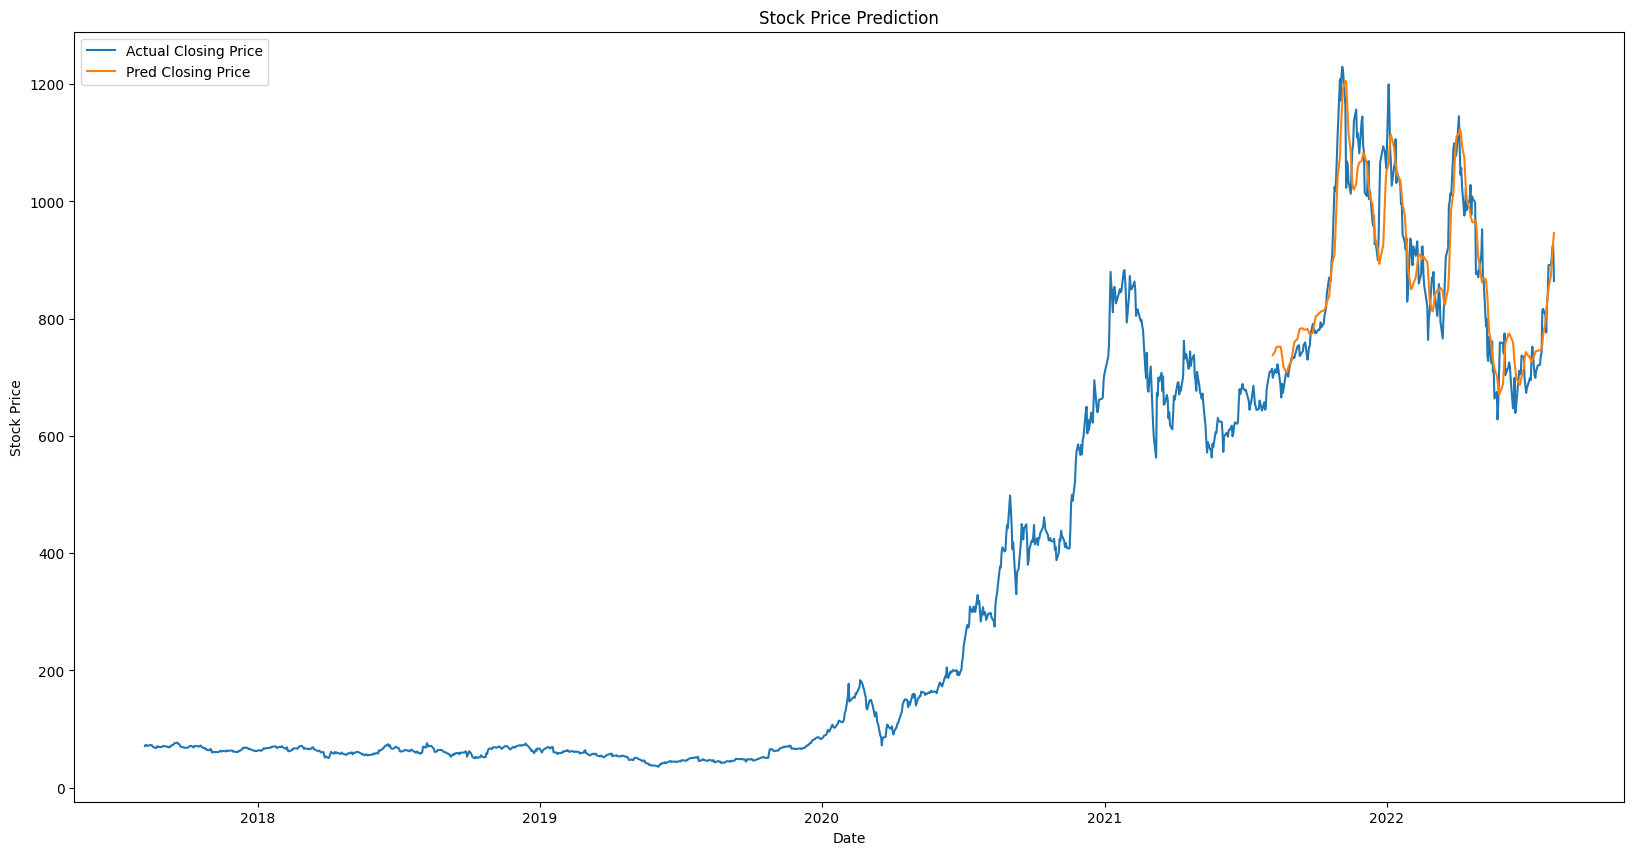

In [14]:
import matplotlib.pyplot as plt


def plots_data_loader(config: TrainerParams, train_size: int):
    dates, y_all_raw = load_data_csv(config.data_path)
    x_test_raw, _ = extract_x_y(y_all_raw, window=config.window, offset=train_size)
    return dates, y_all_raw, x_test_raw


def plotter(
    dates: np.ndarray, train_size: int,
    y_all_raw: np.ndarray, x_test_raw: np.ndarray
):
    endpoint_pred_url = 'http://127.0.0.1:3000/predict'
    rsp = requests.post(endpoint_pred_url, json=x_test_raw.tolist())
    y_pred_raw = np.array(rsp.json())
    
    fig = plt.figure(figsize=(20, 10))
    plt.plot(dates, y_all_raw, label='Actual Closing Price')
    plt.plot(dates[train_size:], y_pred_raw, label='Pred Closing Price')
    plt.title('Stock Price Prediction')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.legend(loc='upper left')


dates, y_all_raw, x_test_raw = plots_data_loader(params, train_size)
plotter(dates, train_size, y_all_raw, x_test_raw)

## Containerize and Deployment

We will write a Bento distribution spec `bentofile.yaml`, build a Bento distribution archive with `bentoml build`, and then build a corresponding Docker image for deployment with `bentoml containerize`.

In [15]:
%%writefile bentoml/bentofile.yaml
service: "service.py:svc"
labels:
  owner: mlteam
  project: stock-pred
include:
- "*.py"
python:
  packages:
    - protobuf==3.20.*  # to avoid "Descriptors cannot not be created directly" error
    - scikit-learn>=1.0.2
    - tensorflow==2.8.0

Overwriting bentoml/bentofile.yaml


In [16]:
!bentoml build bentoml/

2022-11-04 14:12:17.617101: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-04 14:12:17.617131: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Building BentoML service "stock_pred_lstm:umujqjs4a6vgyasc" from build context "/mlsteam/lab/stock-pred/bentoml".
Packing model "stock_pred_lstm:kxkk3ms4a6xckasc"
Locking PyPI package versions.

██████╗░███████╗███╗░░██╗████████╗░█████╗░███╗░░░███╗██╗░░░░░
██╔══██╗██╔════╝████╗░██║╚══██╔══╝██╔══██╗████╗░████║██║░░░░░
██████╦╝█████╗░░██╔██╗██║░░░██║░░░██║░░██║██╔████╔██║██║░░░░░
██╔══██╗██╔══╝░░██║╚████║░░░██║░░░██║░░██║██║╚██╔╝██║██║░░░░░
██████╦╝███████╗██║░╚███║░░░██║░░░╚█████╔╝██║░╚═╝░██║███████╗
╚═════╝░╚══════╝╚═╝░░╚══╝░░░╚═╝░░░░╚════╝░╚═╝░░░░░╚═╝╚══════╝

Successfully built Bento(tag="stock_pred_lst

In [17]:
!bentoml list

 Tag                     Size      Creation Time        Path                    
 stock_pred_lstm:umujq…  1.48 MiB  2022-11-04 14:12:30  ~/bentoml/bentos/stock… 


Now, run the command to build the Docker image:

```bash
bentoml containerize "stock_pred_lstm:latest"
```

After the image is ready, you could run the container by

```bash
docker run --rm -it -p 3000:PORT_EXT stock_pred_lstm:VERSION
```

where `PORT_EXT` is the external container port, and `stock_pred_lstm:VERSION` is the tag listed in the previous `bentoml list` output.

Then, you could use the `curl` commands to run queries against the deployed server.